<a href="https://colab.research.google.com/github/steflhermitte/EO-Notebooks/blob/master/PythonProgramming/RS_Notebook2_Loading_RS_data_in_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


[<img src="https://raw.githubusercontent.com/mbakker7/exploratory_computing_with_python/master/tudelft_logo.png" width="200" align='right'>](https://www.tudelft.nl/citg/over-faculteit/afdelingen/geoscience-remote-sensing/staff/scientific-staff/dr-stef-lhermitte)


# Loading remote sensing data in python 
*Created by Stef Lhermitte (s.lhermitte at tudelft.nl / [@steflhermitte](https://twitter.com/StefLhermitte) | www.earthmapps.io)*

*with inspiration and fragments from:*

* [geemap.org](https://geemap.org/)
* [Google Earth Engine guide](https://developers.google.com/earth-engine/guides)
* [rasterio](https://rasterio.readthedocs.io/en/latest/)


[![Twitter](https://img.shields.io/twitter/url/https/twitter.com/cloudposse.svg?style=social&label=%20%40steflhermitte)](https://twitter.com/steflhermitte)





## Introduction
In this notebook we will learn how to download remote sensing data from Google Earth engine and open them in python using rasterio. After opening the data, you will learn to do multiple types of analyses on the data and finally learn to classify the imagery.

In order to use run this notebook you will need a Google Earth Engine account. If you do not have one yet, create one at [GEE webpage](https://signup.earthengine.google.com/#!/). Google Earth Engine combines a multi-petabyte [catalog](https://developers.google.com/earth-engine/datasets/) of satellite imagery and geospatial datasets with planetary-scale analysis capabilities and makes it available for scientists, researchers, and developers to detect changes, map trends, and quantify differences on the Earth's surface. The public data archive includes more than thirty years of historical imagery and scientific datasets, updated and expanded daily. It contains over twenty petabytes of geospatial data instantly available for analysis.

In this notebook, we will limit the use of GEE and `geemap` to downloading different data sources. GEE offers a multitude of more opportunities and functions to process, analyze and visualize the data in the cloud, but covering these is beyond the scope of this notebook. If you want to know more about GEE functionalities I recommend the excellent [GEE](https://developers.google.com/earth-engine/guides) and [geemap](https://geemap.org/) tutorials and welcome you always in our [Remote Sensing & Big Data course](https://studiegids.tudelft.nl/a101_displayCourse.do?course_id=56333) where all these aspects are covered in more detail.




## Before you start
Before starting this notebook make sure that you installed the necessary packages (see [Python installation example notebook](https://colab.research.google.com/drive/1MccJkybH3jEDeQ8GkU7NmtbXP8ZE4V5M?usp=sharing)). For your local computer, you only need to install the packages once and you won't need the next cell. For Colab, you need to run the following installation steps every time you start a new notebook and restart the environment afterwards. 

In [1]:
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
# !pip install cython
# !pip install git+https://github.com/SciTools/cartopy.git --no-binary cartopy
# !apt-get -qq install python-cartopy python3-cartopy
!pip install cartopy geemap
!pip uninstall -y shapely    # cartopy and shapely aren't friends (early 2020)
!pip install shapely --no-binary shapely
!pip install matplotlib-scalebar
!pip install pyepsg
!pip install owslib
!pip install scikit-learn
!pip install geopandas
!pip install rasterio
!pip install geemap

!apt install libspatialindex-dev
!pip install osmnx

from google.colab import drive
drive.mount('/content/drive')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libproj-dev is already the newest version (4.9.3-2).
libproj-dev set to manually installed.
proj-data is already the newest version (4.9.3-2).
proj-data set to manually installed.
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
The following NEW packages will be installed:
  proj-bin
0 upgraded, 1 newly installed, 0 to remove and 42 not upgraded.
Need to get 32.3 kB of archives.
After this operation, 110 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 proj-bin amd64 4.9.3-2 [32.3 kB]
Fetched 32.3 kB in 0s (154 kB/s)
Selecting previously unselected package proj-bin.
(Reading database ... 155202 files and directories currently installed.)
Preparing to unpack .../proj-bin_4.9.3-2_amd64.deb ...
Unpacking proj-bin (4.9.3-2) ...


Found existing installation: Shapely 1.8.1.post1
Uninstalling Shapely-1.8.1.post1:
  Successfully uninstalled Shapely-1.8.1.post1
     |████████████████████████████████| 198 kB 9.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shapely: filename=Shapely-1.8.1.post1-cp37-cp37m-linux_x86_64.whl size=665638 sha256=b8cf94c40871ff13a145c525d9796063afb27f81121d3e987c8edde733968e57
  Stored in directory: /root/.cache/pip/wheels/ea/8d/2f/ab748b8a432b3c6cd72e751b3bca17c5a9ed4538b1e78467e6
Successfully built shapely
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 216 kB 8.2 MB/s 
     |████████████████████████████████| 6.3 MB 46

If you are missing the `glob2` and `imageio` package on your local computer, you can just install it by running:

In [2]:
%pip install glob2 imageio

For colab users: don't forget to restart your runtime after installation to avoid problems with matplotlib.

## Load the necessary packages

We start by importing the necessary packages

In [1]:
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import geemap
import rasterio
import ee
import geemap
import os
import shutil
import numpy as np
import pandas as pd
import glob2
import imageio
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 12] # to make the default figures larger

Now you need to authenticate Google Earth Engine and launch it in colab.



In [3]:
## Authenticate EE
ee.Authenticate()

In [2]:
# Launch EE
ee.Initialize()

## Accessing your local/colab storage and file structure
Within this notebook you will be saving data to your computer (or colab storage) and subsequently reading it in again (e.g. for analysis). Therefore, you need to have a basic understanding of how to access your folder/file system. Typically the reading and writing functions just take string arguments (e.g. `'/drive/folder1/subfolder1/file1.jpg'`) as inputs, but the way they are formulated might differ between Windows/Mac/Linux/Colab. Windows subfolders are separated by `\` and on Mac/Linux/Colab by `/` (e.g. Downloads/subfolder1/subsubfolder2/). Since `\` is a special character you often need to type it twice. To get an idea on how it looks on your computer You can check your current directory with `os.getcwd` (i.e., get. Current Working Directory).

In [3]:
os.getcwd()

'/Users/slhermitte/surfdrive/GitHub/EO-Notebooks/PythonProgramming'

Subsequently, we can define our own folders. For example, if we want the test subfolder in our Downloads directory you can define that folder manually or by using a `os.path.join` function.



In [4]:
# Get your home directory
home = os.path.expanduser('~')
# Define folder manually
out_dir = home + '/Downloads/test' # On Mac/Linux
print(out_dir)
out_dir = home + '\\Downloads\\test' # On Windows
print(out_dir)
# Or use the os.path.join function to adapt to your computer environment
out_dir = os.path.join(home, 'Downloads','test')
print(out_dir)

/Users/slhermitte/Downloads/test
/Users/slhermitte\Downloads\test
/Users/slhermitte/Downloads/test


We can also use regular expressions to look for files that fullfill certain criteria. If we use `glob2.glob` we can search for a certain pattern in our filees and return a list of filenames. Within such search criteria `*` is a important character as it means "match any character zero or many times". 

In [5]:
# Without *: should give no output as we did not define any character
glob2.glob('/content/sample_data/')

[]

In [6]:
# With *: should give you a list of all files in this folder
glob2.glob('/content/sample_data/*')

[]

Using this pattern, we can search for files with a certain pattern. For example, if we only want the files with a certain extension or starting characters:

In [7]:
# With *.extension: should give only files with .csv extension
glob2.glob('/content/sample_data/*.csv')

[]

In [8]:
# Should give only files with starting with mnist and with .csv extension
glob2.glob('/content/sample_data/mnist*.csv')

[]

## geemap
geemap is a Python package for interactive mapping with Google Earth Engine (GEE). During the past few years, GEE has become very popular in the geospatial community and it has empowered numerous environmental applications at local, regional, and global scales. GEE provides both JavaScript and Python APIs for making computational requests to the Earth Engine servers. Compared with the comprehensive documentation and interactive IDE (i.e., GEE JavaScript Code Editor) of the GEE JavaScript API, the GEE Python API has relatively little documentation and limited functionality for visualizing results interactively. The geemap Python package was created to fill this gap. It is built upon ipyleaflet and ipywidgets, and enables users to analyze and visualize Earth Engine datasets interactively within a Jupyter-based environment. The ipyleaflet or folium interface allows moreover to visualize geospatial data dynamically, allowing to zoom/pan etc.

For example, by running the following cell we will initiate an interactive ipyleaflet map.

In [9]:
Map = geemap.Map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

At the moment this Map is still empty as we did not add any data to it, but we can do that easily using different approaches. 


### Basemaps 
For example we can add different basemaps (see https://geemap.org/basemaps/), which we can toggle in the right corner using the icon 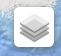 

In [10]:
Map = geemap.Map()
Map.add_basemap('SATELLITE')
Map.add_basemap('ROADMAP')
Map.add_basemap('Esri Ocean')
Map.add_basemap('Esri National Geographic')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

### WMS
Or we can add WMS and XYZ tile layers:

In [11]:
Map = geemap.Map()
# Add XYZ tiles
url = 'https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}'
Map.add_tile_layer(url, name='Google Map', attribution='Google')
# Add WMS tiles
naip_url = 'https://services.nationalmap.gov/arcgis/services/USGSNAIPImagery/ImageServer/WMSServer?'
Map.add_wms_layer(url=naip_url, layers='0', name='NAIP Imagery', format='image/png', shown=True)
# For example last weeks example MODIS example
wv_url = 'https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi'
Map.add_wms_layer(url=wv_url,layers='VIIRS_SNPP_CorrectedReflectance_TrueColor',time='2021-04-01', name='MODIS')
# Or the PDOK imagery
pd_url = 'https://service.pdok.nl/hwh/luchtfotorgb/wms/v1_0'
Map.add_wms_layer(url=pd_url,layers='Actueel_ortho25',name='PDOK',shown=False)
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

### GEE data
Or we can add GEE data ranging from images/image collections to geometries/features/feature collections.



#### Images vs. image collections
When processing data it is important to understand the difference between images and image collections. 
[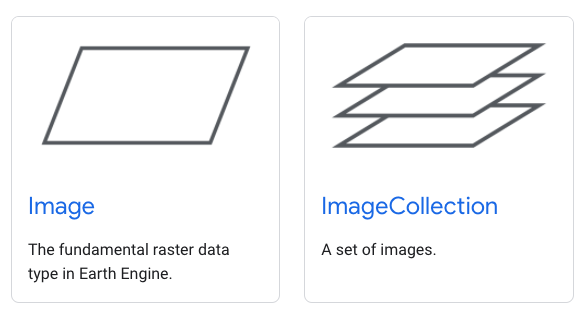](https://developers.google.com/earth-engine/guides/objects_methods_overview)

Images are individual rasters composed of one or more bands and each band has its own name, data type, scale, mask and projection. Each image has metadata stored as a set of properties. Images can be loaded by pasting an Earth Engine asset ID into the `ee.Image()` constructor. You can find image IDs in the [data catalog](https://developers.google.com/earth-engine/datasets). For example, to load the USGS SRTM:

In [12]:
# Define Earth Engine dataset
image = ee.Image('USGS/SRTMGL1_003')

Subsequently, we can add it to our Map by defining some visualization parameters. Here we are going to define only the min/max value to visualize, but you can find additional visualisation parameters [here](https://developers.google.com/earth-engine/guides/image_visualization).

In [13]:
# Set visualization parameters.
vis_params = {
  'min': 0,
  'max': 4000}

# Create Map
Map = geemap.Map()

# Add Earth Engine layers to Map
Map.addLayer(image, vis_params, 'DEM')

# Show map
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

An ImageCollection is a stack or sequence of images. For example, it can be the entire [Sentinel-2 surface reflection collection]('https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR') which contains all Sentinel-2 surface reflectance images over the Earth.

An ImageCollection can be loaded by pasting an Earth Engine asset ID into the `ee.ImageCollection` constructor. You can find ImageCollection IDs in the [data catalog](https://developers.google.com/earth-engine/datasets). 

In [14]:
sentinelCollection = ee.ImageCollection('COPERNICUS/S2_SR');

This collection contains every Sentinel-2 image in the public catalog. There are a lot. Usually you want to filter the collection before. Filtering can occur based on:
 * region of interest / bounds:  to only get images that contain a certain area. Later we will see how to define such an area
 * date: to only get images from a certain date range
 * metadata: to only get images that fulfill a certain metadata requirement (e.g. only images with less than x% cloud cover). To get an idea of the potential metadata, I recommend to have a look at the data catalog -> `Image Properties` for each collection (e.g. for S2: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR)

In [15]:
S2 = (ee.ImageCollection('COPERNICUS/S2_SR')
         .filterBounds(ee.Geometry.Point(4, 52))
         .filterDate('2019-01-01', '2019-12-31')
         .filterMetadata('CLOUDY_PIXEL_PERCENTAGE','less_than',20))

The standard way to get an image out of a collection is to reduce the collection. For example, we can sort based on a metadata field and subsequently get the first image. Notice in the following example that the image appears very dark as the min/max values are 0/10000 (corresponding to relfectance values of 0/1; see scale parameter in [data catalog](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR#bands)), but changing the max-value to a lower valuye will make it clearer.

In [16]:
# Sort and get first image
S2_im = S2.sort('CLOUDY_PIXEL_PERCENTAGE').first()
# Define vis parameters
S2_vis = {'bands':['B4','B3','B2'],
          'min':0,
          'max':10000}
# Initialize Map
Map = geemap.Map()
# Add image
Map.addLayer(S2_im,S2_vis,'S2 first image')
# Zoom map on image on scale level 10
Map.center_object(S2_im,10)

Map

Map(center=[51.89349074798034, 3.5454258558219984], controls=(WidgetControl(options=['position', 'transparent_…

Or apply some basic reduces to get the mean, median etc.

In [17]:
# Get the Mean image of the collection
S2_im = S2.mean()
# Get the Median image of the collection
S2_im2 = S2.median()

# Define vis parameters
S2_vis = {'bands':['B4','B3','B2'],
          'min':0,
          'max':4000}
# Initialize Map
Map = geemap.Map()
# Add image
Map.addLayer(S2_im,S2_vis,'S2 mean')
Map.addLayer(S2_im2,S2_vis,'S2 median')
Map


Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

As you will notice, the `mean` and `median` image are rather different. Can you explain these differences?

#### Geometries in GEE
We can also define geometries in GEE as Earth Engine handles vector data with the Geometry type. GEE support points and polygons but in this example notebook we are going to limit ourselves to points and rectangles. By default these are defined in `EPSG:4326` so lat/lon coordinates. Subsequently we can use these geometries to filter our data or define an output geometry when exporting

In [18]:
# Point based on lon/lat
point = ee.Geometry.Point([1.5, 1.5])
# Rectangle based on (minLon, minLat, maxLon, maxLat).
rectangle = ee.Geometry.Rectangle([4.30,51.95,4.39,52])
# rectangle = ee.Geometry.Rectangle([4.38,51.2,4.9,52])

### Exporting from GEE
geemap also allows to export your data to your local computer using the `.ee_export_image` (for images) and `ee_export_image_collection` (for collections) functions.

To export, we always need to [define](https://geemap.org/common/#geemap.common.ee_export_image):
* `region`: a region of interest (bounding box)
*  `crs`: a coordinate reference system (i.e. projection where the data are exported in) 
* `scale`: the scale (in m) in which the data are exported
* `filename`: output filename for the exported image

To define a filename and folder structure, we need to consider the computer architecture we are working in (e.g., windows, Mac, Linux or Colab). If you are working on a local computer, you can get your local folder (e.g. `Downloads` folder) with:

In [22]:
# If on local computer
out_dir = os.path.join(os.path.expanduser('~'), 'Downloads','test')

If you want other specific folders, you can change the `Downloads` with your local folder. Remember that on Window subsfolder are separated by `\` and on Mac/Linux by `/` (e.g. `Downloads/subfolder1/subsubfolder2/`). Moreover Windows often prefers double `\` (`Downloads\\subfolder1\\subsubfolder2\\`).

On a colab computer mounted to Google drive, your output directory should be `/content/drive/MyDrive` with potential subfolders to save it to your Drive.

In [20]:
# If on colab and you want to download to drive
out_dir = '/content/drive/MyDrive/'
# If on colab and you want to download it to the notebook storage only
out_dir = '/content/'

To define the output file, we need to append the desired output filename to the folder

In [23]:
filename = os.path.join(out_dir, 'S2_SR.tif')
print(filename)

/Users/slhermitte/Downloads/test/S2_SR.tif


And then we can start exporting. When we set `file_per_band=False` all image bands will be exported in one file. If you set it to `True`, each band will be saved to a different file with the band name appended. To understand what the different bands mean, I always recommend to check the data catalog of GEE before exporting.

In [24]:
geemap.ee_export_image(S2_im, filename=filename, scale=10, region=rectangle, file_per_band=False)

Generating URL ...
An error occurred while downloading.
Total request size (115852518 bytes) must be less than or equal to 50331648 bytes.


One of the drawbacks of GEE is that downloads are limited to ~33.5Mb and max 10000 pixel dimensions. To avoid hitting this limit, it is therefore wise to subset to only the bands you need by using the [`select` function](https://developers.google.com/earth-engine/apidocs/ee-image-select). For example, if you only want the RGB+NIR bands you can select `['B4','B3','B2','B8']`. Again I recommend to check the data catalog to understand what these bands mean.

If you hit the download limit it may also be wise to select/download per band.

In [25]:
geemap.ee_export_image(S2_im.select(['B4','B3','B2','B8']), filename=filename, scale=10, region=rectangle, crs='EPSG:3857', file_per_band=False)

Generating URL ...
Please wait ...
Data downloaded to /Users/slhermitte/Downloads/test/S2_SR.tif


Alternatively we can also download image collections using [`ee_export_image_collection`](https://geemap.org/common/#geemap.common.ee_export_image_collection). It is similar to exporting images, but now you only provide a folder you will download every image in your collection.

In [26]:
geemap.ee_export_image_collection(S2.select(['B4','B3','B2']), out_dir=out_dir, scale=10, region=rectangle, crs='EPSG:3857', file_per_band=False)

Total number of images: 31

Exporting 1/31: 20190215T105131_20190215T105128_T31UET.tif
Generating URL ...
Please wait ...
Data downloaded to /Users/slhermitte/Downloads/test/20190215T105131_20190215T105128_T31UET.tif


Exporting 2/31: 20190223T110039_20190223T110040_T31UET.tif
Generating URL ...
Please wait ...
Data downloaded to /Users/slhermitte/Downloads/test/20190223T110039_20190223T110040_T31UET.tif


Exporting 3/31: 20190225T105021_20190225T105315_T31UET.tif
Generating URL ...
Please wait ...
Data downloaded to /Users/slhermitte/Downloads/test/20190225T105021_20190225T105315_T31UET.tif


Exporting 4/31: 20190305T110029_20190305T110032_T31UET.tif
Generating URL ...
Please wait ...
Data downloaded to /Users/slhermitte/Downloads/test/20190305T110029_20190305T110032_T31UET.tif


Exporting 5/31: 20190330T105631_20190330T110608_T31UET.tif
Generating URL ...
Please wait ...
Data downloaded to /Users/slhermitte/Downloads/test/20190330T105631_20190330T110608_T31UET.tif


Exporting 6/31: 2

## Rasterio
Once the data are downloaded we can open them using `rasterio`. Rasterio reads and writes geospatial raster datasets. It employs GDAL under the hood for file I/O and raster formatting. Its functions typically accept and return Numpy ndarrays. Rasterio is designed to make working with geospatial raster data more productive and more fun.

Consider a GeoTIFF file named `S2_SR.tif` we just downloaded. We first need to open it with rasterio

In [27]:
dataset = rasterio.open(filename)

Rasterio’s open() function takes a path string or path-like object and returns an opened dataset object. The path may point to a file of any supported raster format. Rasterio will open it using the proper GDAL format driver. Dataset objects have some of the same attributes as Python file objects.

In [28]:
dataset.name

'/Users/slhermitte/Downloads/test/S2_SR.tif'

Properties of the raster data stored in the example GeoTIFF can be accessed through attributes of the opened dataset object. Dataset objects have bands and this example has a band count of 4 as our latest export were only RGB+NIR bands.

In [29]:
dataset.count

4

A dataset band is an array of values representing the partial distribution of a single variable in 2-dimensional (2D) space. All band arrays of a dataset have the same number of rows and columns.

In [30]:
print(dataset.width)
print(dataset.height)

1003
905


### Raster georeferencing
A GIS raster dataset is different from an ordinary image; its elements (or “pixels”) are mapped to regions on the earth’s surface. Every pixels of a dataset is contained within a spatial bounding box. In this case it are the coordinates in the output `crs` we defined when exporting.



In [31]:
dataset.bounds

BoundingBox(left=478670.0, bottom=6791080.0, right=488700.0, top=6800130.0)

In [32]:
dataset.crs

CRS.from_epsg(3857)

### Reading raster data
Data from a raster band can be accessed by the band’s index number. Following the GDAL convention, bands are indexed from 1 (and not 0 as in most python arrays)

In [33]:
band1 = dataset.read(1)

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


The read() method returns a Numpy N-D array.

In [34]:
band1

array([[ 430. ,  446.9,  446.9, ..., 1079.3,  840.2,  828.9],
       [ 447.7,  458.8,  458.8, ..., 1079.3, 1079.3, 1260.4],
       [ 447.7,  458.8,  458.8, ..., 1476.2, 1476.2, 1633.6],
       ...,
       [ 413.3,  424.3,  424.3, ...,  500.8,  508.8,  508.8],
       [ 443.5,  464.4,  464.4, ...,  500.8,  508.8,  508.8],
       [ 443.5,  464.4,  464.4, ...,  547.7,  538.6,  538.6]])

Instead of reading single bands, all bands of the input dataset can also be read into a 3-dimensonal ndarray. Note that the interpretation of the 3 axes is `(bands, rows, columns)`. 

In [35]:
bands = dataset.read()
bands.shape

(4, 905, 1003)

The interpretation of a 3-dimension array read from rasterio is `(bands, rows, columns)` while image processing software like scikit-image, pillow and matplotlib are generally ordered as `(rows, columns, bands)` where number of rows defines the dataset’s height, the columns are the dataset’s width.

Numpy provides a way to efficiently swap the axis order and you can use the following reshape functions to convert between raster and image axis order:



In [36]:
from rasterio.plot import reshape_as_raster, reshape_as_image
# Convert to image
image = reshape_as_image(bands)
print(image.shape)
# Convert back to raster
raster = reshape_as_raster(image)
print(raster.shape)

(905, 1003, 4)
(4, 905, 1003)


Irrespective to the ordering, values from the array can be addressed by their `band, row, column` index. Notice that now indexing starts again at 0 as in classic python arrays

In [37]:
bands[0, 150, 100]

434.5

## Analyzing & plotting the data
Once the data are downloaded and opened, we can start analyzing and plotting them. For example, if we want to calculate the calculate the `NDVI` (see lectures), we need the normalized ration between R & NIR, which in our case are bands 0 and 3.



In [38]:
ndvi = (bands[0,:,:]-bands[3,:,:])/(bands[0,:,:]+bands[3,:,:])
ndvi

array([[-0.82196091, -0.81489075, -0.81489075, ..., -0.29976968,
        -0.52204335, -0.48793822],
       [-0.81381132, -0.80800134, -0.80800134, ..., -0.29976968,
        -0.29976968, -0.21694831],
       [-0.81381132, -0.80800134, -0.80800134, ..., -0.13388876,
        -0.13388876, -0.1115462 ],
       ...,
       [-0.84688339, -0.83660974, -0.83660974, ..., -0.67944697,
        -0.67085005, -0.67085005],
       [-0.81447008, -0.79749706, -0.79749706, ..., -0.67944697,
        -0.67085005, -0.67085005],
       [-0.81447008, -0.79749706, -0.79749706, ..., -0.65157925,
        -0.65075866, -0.65075866]])

We can off course also plot the data in a map using the mapping tools you learned in notebook 1.

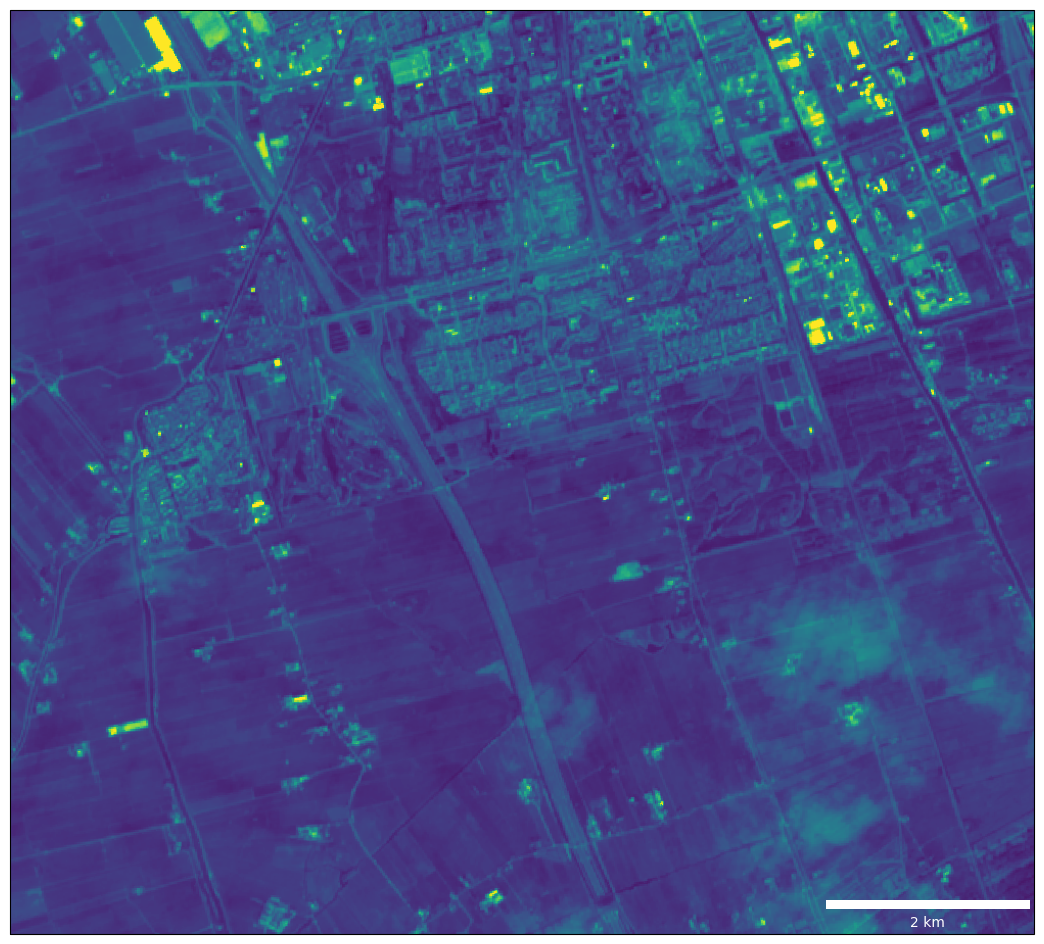

In [39]:
plt.figure()
crs=ccrs.epsg(3857)
ax = plt.axes(projection=crs)
img_extent = [dataset.bounds.left,dataset.bounds.right,dataset.bounds.bottom,dataset.bounds.top]
ax.set_extent(img_extent,crs=crs)
ax.imshow(bands[0,:,:],vmin=0,vmax=3000, extent=img_extent, origin='upper')
scalebar = ScaleBar(1,box_alpha=0,color='white',location='lower right')
ax.add_artist(scalebar)

Or show it as an image using the reshape_as_image function and by rescaling the data to 0-1 range. Remember that the original data are integers that need rescaling to fit in the 0-1 range (see data catalog and scaling value)


Often this image is still rather dark. To understand why, you can plot a histogram of the band values.

Text(0, 0.5, 'Probability density by counts')

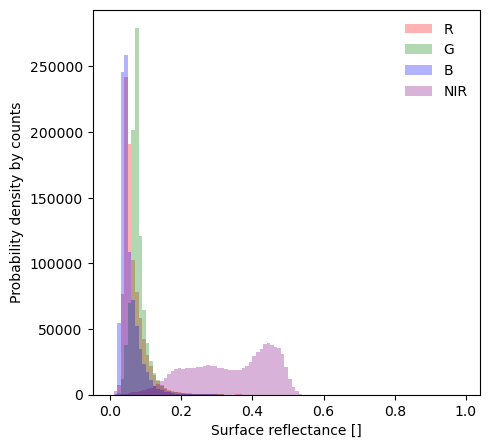

In [40]:
# First rescale the values to reflectance values
im = bands/10000. # see the data catalog where the scale value is 0.0001
# Plot
plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.hist(im[0,:,:].flatten(),bins=np.arange(0, 1, 0.01),color='red',alpha=0.3,label='R')
ax.hist(im[1,:,:].flatten(),bins=np.arange(0, 1, 0.01),color='green',alpha=0.3,label='G')
ax.hist(im[2,:,:].flatten(),bins=np.arange(0, 1, 0.01),color='blue',alpha=0.3,label='B')
ax.hist(im[3,:,:].flatten(),bins=np.arange(0, 1, 0.01),color='purple',alpha=0.3,label='NIR')
ax.legend(frameon=False,fontsize=10)
ax.set_xlabel('Surface reflectance []')
ax.set_ylabel('Probability density by counts')

The figure shows that for the RGB bands the reflectance values are indeed rather low (`<0.2`) resulting in a dark image. If we plot a false color `NIR/R/G` composite, we can indeed see that most of the image turns red as a result of the stronger reflectance of vegetation in the NIR band.

If we want to adjust the scaling, we can just apply offset and scaling values to increase brightness or contrast (see lecture slides).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


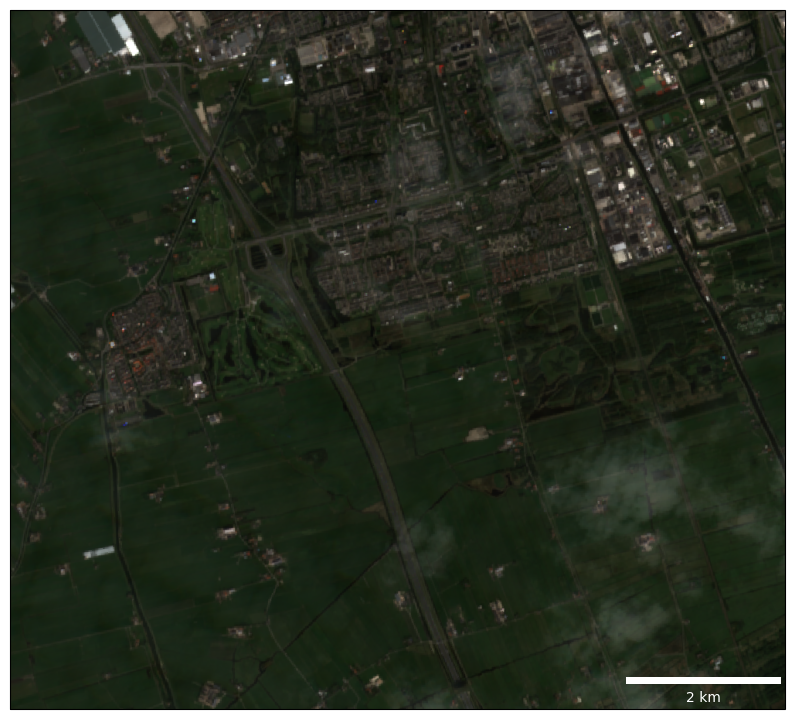

In [41]:
scaling = 2
offset = 0
image = reshape_as_image(bands)/10000.*scaling + offset
plt.figure(figsize=(10,10))
crs=ccrs.epsg(3857)
ax = plt.axes(projection=crs)
img_extent = [dataset.bounds.left,dataset.bounds.right,dataset.bounds.bottom,dataset.bounds.top]
ax.set_extent(img_extent,crs=crs)
ax.imshow(image[:,:,0:3], extent=img_extent, origin='upper')
scalebar = ScaleBar(1,box_alpha=0,color='white',location='lower right')
ax.add_artist(scalebar)

# Classifying the image
Once we have downloaded the image, we can also classify it. In the next steps we are going to do a supervised classification / machine learning exercise on one of your previously downloaded satellite images. Machine learning  is establishing the relationship between a few characteristics (features or Xs; in this case satellite reflectance) of an entity with its other property (value or label or Y; in this case landuse type). Features are essentially the same as variables in a scientific experiment, they are characteristics of the phenomenon under observation that can be quantified or measured in some fashion. When these features are fed into a machine learning framework the network tries to discern relevant patterns between the features. These patterns are then used to generate the outputs of the framework/network. The outputs of the framework are often called "labels", as the output features have some label given to them by the network, some assumption about what category the output falls into. 

In a machine learning context, classification is a type of supervised learning. Supervised learning means that the data fed to the network is already labeled, with the important features/attributes already separated into distinct categories beforehand. This means that the network knows which parts of the input are important, and there is also a target or ground truth that the network can check itself against. 

The process of training a model is the process of feeding data into a neural network and letting it learn the patterns of the data. The training process takes in the data and pulls out the features of the dataset. During the training process for a supervised classification task the network is passed both the features and the labels of the training data. However, during testing, the network is only fed features.

The testing process is where the patterns that the network has learned are tested. The features are given to the network, and the network must predict the labels. The data for the network is divided into training and testing sets, two different sets of inputs. You do not test the classifier on the same dataset you train it on, as the model has already learned the patterns of this set of data and it would be extreme bias.

Instead, the dataset is split up into training and testing sets, a set the classifier trains on and a set the classifier has never seen before. 

Scikit-Learn provides easy access to numerous different classification algorithms. Among these classifiers are:
 - [K-Nearest Neighbors](https://stackabuse.com/k-nearest-neighbors-algorithm-in-python-and-scikit-learn/)
 - [Support Vector Machines](https://stackabuse.com/implementing-svm-and-kernel-svm-with-pythons-scikit-learn/)
 - [Decision Tree Classifiers](https://stackabuse.com/decision-trees-in-python-with-scikit-learn/)/[Random Forests](https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/)
 - [Naive Bayes](https://stackabuse.com/the-naive-bayes-algorithm-in-python-with-scikit-learn/)
 - [Linear Discriminant Analysis](https://stackabuse.com/implementing-lda-in-python-with-scikit-learn/)
 
Classification tasks are any tasks that have you putting examples into two or more classes. Determining if an image is a cat or dog is a classification task, as is determining what the classifying satellite pixels in different classes.

Depending on the classification task at hand, you will want to use different classifiers. For instance, a logistic regression model is best suited for binary classification tasks, even though multiple variable logistic regression models exist. As you gain more experience with classifiers you will develop a better sense for when to use which classifier. However, a common practice is to instantiate multiple classifiers and compare their performance against one another, then select the classifier which performs the best.

In the next step you are going to do an image classification of your neightborhood using the spectral characteristics of the satellite and some labels that you need to digitise yourself. In this example, we are going to read the labels from Open Streetmap, but in your assignment you will digitise the labels manually.

### Load the necessary packages

In [42]:
import cartopy.crs as ccrs
import osmnx as ox
from pyproj import CRS
import geopandas
import geemap
import ee
import rasterio
import rasterio.features
from rasterio.plot import reshape_as_raster, reshape_as_image
import os
import glob2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

## Creating pixel labels for classification
Before starting a satellite classification exercise, we need pixel labels that identify each pixel to a class (e.g. the landcover type). These labels could come from an external data set, or could be manually created. 

### Loading labels

For example, we could load them from OpenStreetmap (See Notebook 1, for how to do this):

In [43]:
bl=ox.geometries.geometries_from_bbox(north=52.01, south=51.98, east=4.39, west=4.36,tags={'building': True})

In [44]:
lu=ox.geometries.geometries_from_bbox(north=52.01, south=51.98, east=4.39, west=4.36,tags={'landuse': True})

From these OpenStreetMap polygons, we can, for example, subsequently select only the landuse classes that are either grass (`lu['landuse']=='grass'`) or forest (`lu['landuse']=='grass'`)

In [45]:
# Create vegetation class by selecting only grass and forest from the landuse
gr=lu[lu['landuse']=='grass']
fo=lu[lu['landuse']=='forest']
print(gr)

                      barrier  \
element_type osmid              
way          32017869     NaN   
             32738712     NaN   
             42621237     NaN   
             45873458     NaN   
             45878128     NaN   
...                       ...   
relation     14189171     NaN   
             14275528     NaN   
             15579234     NaN   
             15744268     NaN   
             15788144     NaN   

                                                                geometry name  \
element_type osmid                                                              
way          32017869  POLYGON ((4.37070 52.00186, 4.37067 52.00185, ...  NaN   
             32738712  POLYGON ((4.36953 52.00053, 4.36950 52.00052, ...  NaN   
             42621237  POLYGON ((4.37582 52.00799, 4.37591 52.00789, ...  NaN   
             45873458  POLYGON ((4.38705 51.99949, 4.38710 51.99931, ...  NaN   
             45878128  POLYGON ((4.38975 52.00360, 4.38972 52.00354, ...  NaN   
...

Or digitalise them manually (e.g. [geojson.oi](http://www.geojson.io), see short [introduction video](https://tudelft.zoom.us/rec/share/zpHPYR8Nz3KbRUi1Jb7H-wW6f59jbEP6RitC_HlTf5g4wkFhA__16q6WKsOkIVAh.OxaRB6K9itNs_NSp) (Passcode: `+=&1$JUX`) on how to digitise using geojson.io) and open the created polygon that contains the polygons for manually defined class. For example, in this example, we manually digitised a water class with two polygons and saved it as a water.json file.

![](https://github.com/steflhermitte/EO-Notebooks/blob/master/PythonProgramming/water_geojson.png?raw=1)

We can load this digitised geojson polygons as geopandas (See also Notebook 1):

In [ ]:
filename='/content/water.geojson'
water = geopandas.read_file(filename)
water = water.set_crs(epsg=4326)
water

### Loading satellite imagery

These polygons are vectors and in the classsification we need raster labels (i.e. every pixel needs to have a label). Therefore, we need to rasterize the polygons. Before doing that we need to load the satellite image we want to classify in order to copy the image extent, geometry, etc. Based on examples we have seen earlier in this notebook we can load the satellite imagery:

In [47]:
# Define region of interest
rectangle = ee.Geometry.Rectangle([4.36, 51.98, 4.39, 52.01])
# Load collection and filter by region, data and cloud cover metadata
S2 = (ee.ImageCollection('COPERNICUS/S2_SR')
         .filterBounds(rectangle)
         .filterDate('2021-01-01', '2021-12-31')
         .filterMetadata('CLOUDY_PIXEL_PERCENTAGE','less_than',20))
# Subset to take only reflectance bands starting with B
S2 = S2.select('B.*')

In [ ]:
# Export imagery
out_dir = '/content/'
geemap.ee_export_image_collection(S2, out_dir='/content', scale=10, region=rectangle, file_per_band=False, crs='EPSG:3857')

Total number of images: 11

Exporting 1/11: 20210125T105331_20210125T105443_T31UET.tif
Generating URL ...
Please wait ...
Data downloaded to /content/20210125T105331_20210125T105443_T31UET.tif


Exporting 2/11: 20210326T105031_20210326T105256_T31UET.tif
Generating URL ...
Please wait ...
Data downloaded to /content/20210326T105031_20210326T105256_T31UET.tif


Exporting 3/11: 20210331T104619_20210331T104618_T31UET.tif
Generating URL ...
Please wait ...
Data downloaded to /content/20210331T104619_20210331T104618_T31UET.tif


Exporting 4/11: 20210420T104619_20210420T104615_T31UET.tif
Generating URL ...
Please wait ...
Data downloaded to /content/20210420T104619_20210420T104615_T31UET.tif


Exporting 5/11: 20210530T104619_20210530T104621_T31UET.tif
Generating URL ...
Please wait ...
Data downloaded to /content/20210530T104619_20210530T104621_T31UET.tif


Exporting 6/11: 20210609T104619_20210609T105522_T31UET.tif
Generating URL ...
Please wait ...
Data downloaded to /content/20210609T104619

Then we can make a list of the filenames (see earlier examples):

In [48]:
# Create a list of the exported images
filelist = glob2.glob(out_dir+'*.tif')
# Print filelist to check contents
filelist

[]

and select one of the files. E.g. `filelist[0]` gives the first file of this list, `filelist[1]` the second etc.

In [ ]:
image_file = filelist[0]

Then we can read in the file using rasterio (Similar to earlier examples in this Notebook)

In [ ]:
# Read image using rasterio
imr = rasterio.open(image_file)
im = imr.read()
im.shape

(12, 543, 335)

The satellite images are raster values between `0` a `10000`, so they need to be rescaled and converted to image format:

In [ ]:
# Apply image scaling (see metadata) to set to reflectance
im = im * 0.0001
im = reshape_as_image(im)
im.shape


(543, 335, 12)

### Rasterize labels into training image

Subsequently, the polygons we have from OpenStreetMap or after manual digitization can be rasterized using the [rasterio rasterize function](https://rasterio.readthedocs.io/en/stable/api/rasterio.features.html#rasterio.features.rasterize). Before doing this, we need to assure that our vectors with labels and imagery have the same projection. Therefore, in this case, we need to reproject to 'EPSG:3857' since we also exported the satellite imagery in this format. However, the choice of projection system always depends on your choice (for a specific project) and can be adapted if needed.

In [ ]:
# Reproject OSM footprints
bl2 = ox.project_gdf(bl,to_crs=CRS.from_epsg(3857))
gr2 = ox.project_gdf(gr,to_crs=CRS.from_epsg(3857))
fo2 = ox.project_gdf(fo,to_crs=CRS.from_epsg(3857))

Or you can reproject the manually defined polygons (which you have read in before as geopandas) using the `to_crs()` geopandas function:

In [ ]:
# Reproject mannually defined polygons
wa2 = water.to_crs(epsg=3857)

Once the data are in corresponding projection systems, we can rasterize our label vectors to label images using the rasterize function:

In [ ]:
?rasterio.features.rasterize

When applying the `rasterize` function, we assign different labels to each class using the `[(x, label) for x in features]` line. In this list, that contains a `for`-loop we  loop over all features and make a tuple per features that contains `(feature,label)`:

In [ ]:
gr_pol = [(x, 1) for x in gr2['geometry']]
gr_pol

[(<shapely.geometry.polygon.Polygon at 0x7f13718591d0>, 1),
 (<shapely.geometry.polygon.Polygon at 0x7f1371859b90>, 1),
 (<shapely.geometry.polygon.Polygon at 0x7f1371859b50>, 1),
 (<shapely.geometry.polygon.Polygon at 0x7f1371859d50>, 1),
 (<shapely.geometry.polygon.Polygon at 0x7f1371859050>, 1),
 (<shapely.geometry.polygon.Polygon at 0x7f1371859c90>, 1),
 (<shapely.geometry.polygon.Polygon at 0x7f1371859bd0>, 1),
 (<shapely.geometry.polygon.Polygon at 0x7f1371859dd0>, 1),
 (<shapely.geometry.polygon.Polygon at 0x7f1371859410>, 1),
 (<shapely.geometry.polygon.Polygon at 0x7f1371859a50>, 1),
 (<shapely.geometry.polygon.Polygon at 0x7f1371859a10>, 1),
 (<shapely.geometry.polygon.Polygon at 0x7f13718599d0>, 1),
 (<shapely.geometry.polygon.Polygon at 0x7f1371859990>, 1),
 (<shapely.geometry.polygon.Polygon at 0x7f1371859950>, 1),
 (<shapely.geometry.polygon.Polygon at 0x7f1371859910>, 1),
 (<shapely.geometry.polygon.Polygon at 0x7f1371859490>, 1),
 (<shapely.geometry.polygon.Polygon at 0

In the output above you can see that it is a list of typles that contain for every grass polygon, the label `1`. Similarly, we can make such a list for the polygons of the other classes, where we assign `class=2` to forest and `class=3` to buildings.

In [ ]:
fo_pol = [(x, 2) for x in fo2['geometry']]
bl_pol = [(x, 3) for x in bl2['geometry']]

Now we can merge these lists of polygons and labels into one large list:

In [ ]:
polygon_labels = gr_pol+fo_pol+bl_pol
# polygon_labels

Next, we can convert the polygon+labels to a raster using rasterio.features.rasterize.

For example, we assign the `class=1` to water, `class=2` to vegetation and `class=3` to buildings and we use the image shape (`imr.shape`) and projection (`imr.transform`). Note also that after the first call, we specify `out=lab` to make sure that the rasterized version are burned into the previous version of `lab`.  If not specified the file is overwritten.

In [ ]:
lab = rasterio.features.rasterize(
    polygon_labels, # The (polygon, label) tuples to restarize
    out_shape=imr.shape,                 # Defines output shape of the raster
    transform=imr.transform,             # Defines output projection/transform of the raster
    fill=0,                              # Defines fill  value
    all_touched=True,                    # If True, all pixels touched by geometries will be burned in.
    dtype=rasterio.float32, )            # Data types

If we now simply plot the rasterized polygons, we see that each polygon is burned in an empty raster with the corresponding label (i.e., 0 for no data, 1 for gras, 2 for forest, 3 for building)

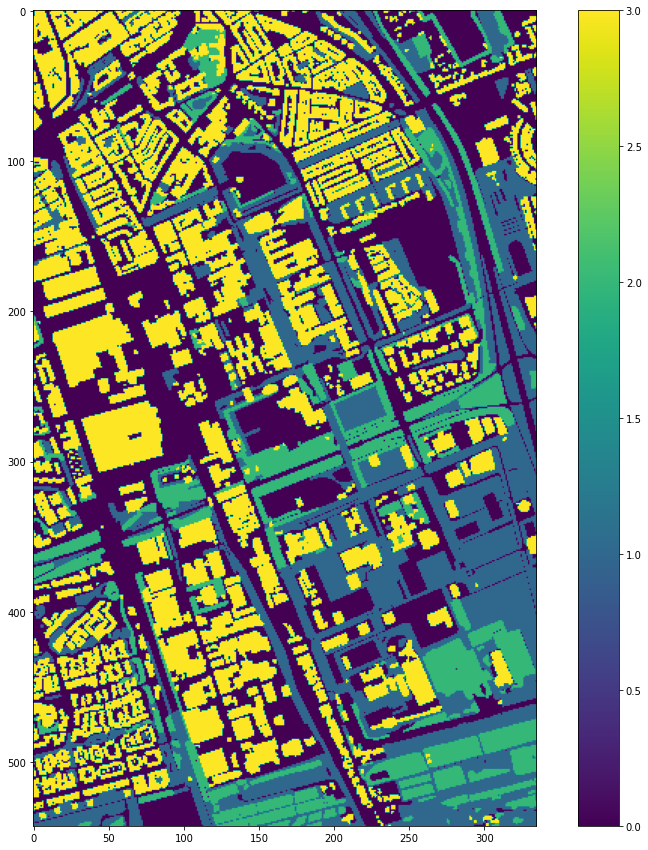

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(15,15))
imp = ax.imshow(lab)
fig.colorbar(imp, ax=ax)

## Training the classification

Once we have the labels, now let's see how to implement a classifier. 
The first step in implementing a classifier is to import the classifier you need into Python. Let's look at the import statement for K-Nearest Neighbors:

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

Scikit-Learn has other classifiers as well, and their respective documentation pages will show how to import them, but in general it is very similar:

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


### Defining a classifier
After this, the classifier must be instantiated. Instantiation is the process of bringing the classifier into existence within your Python program - to create an instance of the classifier/object.

This is typically done just by making a variable and calling the function associated with the classifier:

In [ ]:
KNN_model = KNeighborsClassifier()
SVC_model = SVC()
RFC_model = RandomForestClassifier()

We can off course further finetune the classifier by adding additional arguments to the initiation. See the help for each classifier for more information.

In [ ]:
?KNeighborsClassifier

Now the classifier needs to be trained. In order to accomplish this, the classifier must be fit with the training data. The model will learn to decide on a pixel class based on the respective reflectane values across all the bands.

Therefore we need to extract both the pixel labels and pixel reflectance data. In order to do this we need to reorganize the image data as the multispectral image should have the same number of features (bands) stacked in the same order. This implies changing the shape of the image to a two-dimensional array, which is expected by the majority of ML algorithms, where each row represents a pixel. 

![](https://miro.medium.com/max/4048/1*DP57Bv0fS9oIWP2Bdvm4-A.jpeg)

The current shape of the image is 543x335 pixels x 12 bands:

In [ ]:
print(im.shape)

(543, 335, 12)


and we reshape it to a matrix where each pixel represents a row and each band represents a column:

In [ ]:
mat_ft=np.reshape(im,(-1, 12)) # Reshape the image to number-of-pixels x number-of-bands
print(np.shape(mat_ft))

(181905, 12)


Similarly we need to reshape the labels to a one-column label per pixel:

In [ ]:
mat_lb=np.reshape(lab,(-1,1)) # Reshape the image to numbber-of-pixels x number-of-labels
print(np.shape(mat_lb))

(181905, 1)


Subsequently, we remove all pixels without a class by subsetting to only the pixels that have a class (i.e., in our example all pixels with 'label=o'). So if we look at the label column we can get the labels by

In [ ]:
mat_lb[:,0]

array([0., 3., 3., ..., 1., 1., 1.], dtype=float32)

and subsequently use that to only subset to the rows (i.e. pixels) where the label is not 0 (i.e. `mat_lb[:,0]!=0`)

In [ ]:
mat_ft=mat_ft[mat_lb[:,0]!=0,:]
mat_lb=mat_lb[mat_lb[:,0]!=0,:]
print(np.shape(mat_ft))
print(np.shape(mat_lb))

(114979, 12)
(114979, 1)


If we do this, you can see that the amount of pixels reduces from 181905 to 114979.

### Understanding the class reflectances
If we want to understand how these classes look like in the satellite data, we can plot the mean +- standard deviation for each class in a spectral plot. This gives us an idea of the spectra of each class and how well these can be separated.


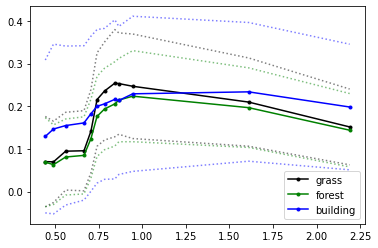

In [ ]:
# Define the wavelengths corresponding to the satellite bands
wl=[0.443,0.490,0.560,0.665,0.705,0.740,0.783,0.842,0.865,0.945,1.610,2.190]
colors=['black','green','blue']
clas= ['grass','forest','building']

for i,color in enumerate(colors):
    plt.plot(wl,np.mean(mat_ft[mat_lb[:,0]==i+1],axis=0),color=color,linestyle='-',marker='.',label=clas[i])
    plt.plot(wl,np.mean(mat_ft[mat_lb[:,0]==i+1],axis=0)+np.std(mat_ft[mat_lb[:,0]==i+1],axis=0),color=color,linestyle=':',alpha=.5)
    plt.plot(wl,np.mean(mat_ft[mat_lb[:,0]==i+1],axis=0)-np.std(mat_ft[mat_lb[:,0]==i+1],axis=0),color=color,linestyle=':',alpha=.5)
plt.legend()

In the previous plot, we see the typical characteristics of each class with a low reflectance of water, a high reflectance of vegetation in the NIR bands and an intermediate signal of built-up area.


### Splitting in training/testing
Once the data has been preprocessed, the data must be split into training and testing sets. This is done to make sure that the model has not seen the test data and it performs equally well on new data. Otherwise, the model will overfit and perform well only on training data. Splitting can easily be done in Scikit-Learn with a helpful function called train_test_split. In the next example, we take 30% for testing and 70% for training as you can see in the resulting sizes

In [ ]:
xTrain, xTest, yTrain, yTest = train_test_split(mat_ft, mat_lb, test_size=0.3)

print(xTrain.shape)
print(yTrain.shape)

print(xTest.shape)
print(yTest.shape)

(80485, 12)
(80485, 1)
(34494, 12)
(34494, 1)


### Train the model
Once we have training data, we can start training the model. This can be done easily with the `fit` command that will fit a model between the labels (i.e. Y data, in this case the landcover classes) and the features (i.e. X data,  in this case the spectral reflectance) The training features and the training labels are passed into the classifier with the fit command:

In [ ]:
KNN_model.fit(xTrain, yTrain.ravel())

KNeighborsClassifier()

### Apply the model
After the classifier model has been trained on the training data, we can apply the model and use it to make predictions on the testing data.

This is easily done by calling the predict command on the classifier and providing it with the parameters it needs to make predictions about, which are the features in your testing dataset:

In [ ]:
KNN_prediction = KNN_model.predict(xTest)
KNN_prediction

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:498: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  counts = np.zeros(a_view.shape[:-1], dtype=np.int)


array([2., 1., 1., ..., 1., 1., 3.], dtype=float32)

Or we can apply the model to all pixels in our dataset

In [ ]:
# Reread data
mat_ft1=np.reshape(im,(-1, 12)) # Reshape the image to number-of-pixels x number-of-bands
# Predict
KNN_pred1 = KNN_model.predict(mat_ft1)
# Reshape predicted back to image
im_pred = np.reshape(KNN_pred1, (imr.height, imr.width))

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:498: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  counts = np.zeros(a_view.shape[:-1], dtype=np.int)


The result of this `predict` is a predicted class for each testing pixel based on the reflectances of that pixel.

### Classifier evaluation
Once we have trained and applied our model, we should evaluate how the classifier performed. There are multiple methods of evaluating a classifier's performance (see also lecture 2). One way to do it is to compare the labels of the test data, which were not used when fitting the model, with the predicted labels. This is also the reason why you need to split between training and testing data sets.

To do this iin Scikit-Learn you just pass in the predictions against the ground truth labels which were stored in your test labels. When doing this, you can calculate the accuracy, the confusion matrix or other derived accuracy statistics:

In [ ]:
# Accuracy score is the simplest way to evaluate
print('Accuracy KNN:\n',accuracy_score(KNN_prediction, yTest))
# But Confusion Matrix and Classification Report give more details about performance
print('Confusion KNN:\n',confusion_matrix(KNN_prediction, yTest))
print('Class report KNN:\n',classification_report(KNN_prediction, yTest))

Accuracy KNN:
 0.861541137589146
Confusion KNN:
 [[10021   958  1091]
 [  904  4684   528]
 [  861   434 15013]]
Class report KNN:
               precision    recall  f1-score   support

         1.0       0.85      0.83      0.84     12070
         2.0       0.77      0.77      0.77      6116
         3.0       0.90      0.92      0.91     16308

    accuracy                           0.86     34494
   macro avg       0.84      0.84      0.84     34494
weighted avg       0.86      0.86      0.86     34494



Similarly, it can be insightfull to make a map of your classified input vs output

## Extrapolation of model
Finally, after testing/validation, the classifier can also be applied to the complete dataset or a different image:

In [ ]:
# Select a different file from the list
image_file = filelist[3]
# Read image using rasterio
imr2 = rasterio.open(image_file)
im2 = imr2.read()
# Apply image scaling (see metadata) to set to reflectance
im2 = im2 * 0.0001
im2 = reshape_as_image(im2)

In [ ]:
# Reshape
mat_ft2=np.reshape(im2,(-1, 12)) # Reshape the image to number-of-pixels x number-of-bands
# Predict
KNN_pred2 = KNN_model.predict(mat_ft2)
print('Shape of KNN_pred2:',KNN_pred2.shape)
# Reshape predicted back to image
im2_pred = np.reshape(KNN_pred2, (imr2.height, imr2.width))
print('Shape of im2_pred2:',im2_pred.shape)

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:498: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  counts = np.zeros(a_view.shape[:-1], dtype=np.int)


Shape of KNN_pred2: (181905,)
Shape of im2_pred2: (543, 335)


Now you can make a map to check how the classifier performed.

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(15,15))
imp = ax.imshow(im2_pred)
fig.colorbar(imp, ax=ax)